# Project 3: Web APIs & Classification
## Problem Statement
The intend of this project is to build different classification models that can accurately classify between subreddit topics based on text posts and find out which model gives the best accuracy.

### General approach
- Scrape subreddit data
- Clean text, lemmatize and remove stopwords
- Convert processed text to vectors using countvectorizor or tf-idf
- Perform grid search over all parameters for all models
- Evaluate models base on accuracy score
- Find out frequently occuring words that are classified correctly and wrongly


In [1]:
import pandas as pd
import numpy as np
import requests
import time
import random
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import regex as re


- Get subreddit data from local drive. If not found, proceed to scrape from reddit website.

In [2]:
def get_subreddit_data(subreddit):
    try: df = pd.read_csv(f'data/{subreddit}.csv', index_col=0)
    except OSError: 
        print(f'{subreddit} not found, proceed to scrape')
        df = scrape_subreddit(subreddit) # scrape subreddit if csv not found
    return df

- Function to scrape from reddit website

In [3]:
def scrape_subreddit(subreddit):
    posts = []
    url = current_url = f'https://reddit.com/r/{subreddit}.json'
    print(f'Scraping {subreddit}...')
    for _ in range(40): # 25*40 = 1000
        res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
        if res.status_code != 200:
            print('Status error', res.status_code)
            break
        current_dict = res.json()
        after = current_dict['data']['after']
        if after:
            current_url = f'{url}?after={after}'
            current_posts = [p['data'] for p in current_dict['data']['children']]
            posts.extend(current_posts)
            print(f'Scrapped {len(posts)} post...')
            sleep_duration = random.randint(2,6)
            time.sleep(sleep_duration)
        else: break  # Break out of loop if after is None
    pd.DataFrame(posts).to_csv(f'data/{subreddit}.csv') # Save posts to ./data/csv
    print()
    return pd.DataFrame(posts)     

- Function to clean reddit data

In [4]:
def clean_text(raw_text, customize_stops):
    raw_text = re.sub(r'http[s]{0,1}://[^\s]*', '', raw_text) # Strip urls
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) # Remove non-letters
    
    words = letters_only.lower().split() # Convert to lower case, split to individual words
    stops = set(stopwords.words('english')) # Default storpwords
    stops.update(customize_stops) # Add customize stopwords
    meaningful_words = [w for w in words if w not in stops]  
    p_stemmer = PorterStemmer()
    meaningful_words = [p_stemmer.stem(i) for i in meaningful_words] # Stem words
    
    return(" ".join(meaningful_words))

- Main functions 
(Output of get_clean_subreddits is the input of classify_subreddits)

In [5]:
def get_clean_subreddits(subreddit_0, subreddit_1, customize_stops={}):
    df_0 = get_subreddit_data(subreddit_0)
    df_1 = get_subreddit_data(subreddit_1)
    print()
    print(f'Number of rows in subreddit {subreddit_0} : {df_0.shape[0]}')
    print(f'Number of rows in subreddit {subreddit_1} : {df_1.shape[0]}')
    df = pd.concat([df_0, df_1], sort=False)  # concat df of 2 subreddits
    df = df.reset_index().drop(columns='index')
    df['selftext'] = df['selftext'].fillna('')  # fillna values with ''
    df['text'] = df[['selftext','title']].astype(str).apply(''.join,1)  # join selftext and title columns 
    df['text'] = df['text'].apply(clean_text, customize_stops=customize_stops)  # apply clean_text function to text
    X = df['text']
    y = df['subreddit']
    print(f'Baseline accuracy: {y.value_counts(normalize=True).max()}')
    print()
    print('Displaying first 5 rows of cleaned data and labels...')
    display(df[['text','subreddit']].head())
    
    return X,y,df

In [6]:
def classify_subreddits(X, y, model='lr'):
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
    models = {
        'lr': LogisticRegression(solver='lbfgs'),
        'knn': KNeighborsClassifier(),
        'nb': MultinomialNB(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
        'ada': AdaBoostClassifier(),
        'gb': GradientBoostingClassifier()
    }
    
    # Building a pipeline
    pipeline = Pipeline([
        ('cvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (model, models[model])
    ])
    
    # Setting base pipeline parameters
    parameters = {
        'cvec__max_df': (0.5, 1.0), # Ignore words more than x% 
        'cvec__max_features': (2500, 5000, 10000),
        'cvec__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False)
    }
    
    # Additional parameters for different models
    if model == 'lr':
        parameters.update({'lr__penalty': ('none','l2')})
    elif model == 'knn':
        parameters.update({
            'knn__n_neighbors':[3,5,11],
            'knn__weights':['uniform','distance'],
#             'knn__metric':['euclidean','manhattan']
        })
    elif model == 'nb':
        parameters.update({'nb__alpha':(1,2)})
    
    elif model == 'rf':
        parameters.update({
            'rf__n_estimators': [100,150],
            'rf__max_depth': [1,2,None]
        })
    elif model == 'et':
        parameters.update({
            'et__n_estimators': [50,100,150]
        })
    elif model == 'ada':
        parameters.update({
            'ada__n_estimators': [50,75,100]
        })
        
    # Perfrom grid search
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    print()
    grid_search.fit(X_train, y_train)
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print()  
    
    # Retrain model using best parameters with entire train set
    pipeline_final = Pipeline([
        ('cvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (model, models[model])
    ])
    pipeline_final.set_params(**grid_search.best_params_)
    final_model = pipeline.fit(X_train,y_train)
    print('Final model score')
    print()
    print(f'Train score: {final_model.score(X_train,y_train)}') 
    print(f'Test score: {final_model.score(X_test,y_test)}')
    
    predictions = final_model.predict(X_test)
    confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    return X_test,y_test, final_model.predict(X_test)

In [7]:
def run_all_models(X,y):
    models = {
    'lr': 'Logistic Regresson',
    'knn': 'K Nearest Neighbours',
    'nb': 'Naive Bayes',
    'rf': 'Random Forest',
    'et': 'Extra Trees',
    'ada': 'Ada Boost',
    }

    models_pred = {m:None for m in models}

    for model in models:
        print(f'----------------------- {models[model]} ------------------------')
        models_pred['text'],models_pred['label'],models_pred[model] = classify_subreddits(X, y, model=model)
        print()

    cols = ['text','lr','knn','nb','rf','et','ada','label']
    model_df = pd.DataFrame(models_pred)[cols]
    return model_df

## Subreddit of Datascience and Learnprogramming

In [8]:
X,y,df = get_clean_subreddits('datascience', 'learnprogramming', 
                    customize_stops={'datascience','learnprogramming','lt','gur','cur','gt','amp','data'})


Number of rows in subreddit datascience : 827
Number of rows in subreddit learnprogramming : 976
Baseline accuracy: 0.5413200221852468

Displaying first 5 rows of cleaned data and labels...


,text,subreddit
0,bleep bloop welcom week enter transit thread t...,datascience
1,r grown consider past year k subscrib jan k su...,datascience
2,hello everyon current scienc traine start amaz...,datascience
3,interview come task scientist actual dataset r...,datascience
4,hi everyon senior tax account one big four stu...,datascience


### Models

In [9]:
ds_lp_df = run_all_models(X,y)

----------------------- Logistic Regresson ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'lr']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'lr__penalty': ('none', 'l2'),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.7s finished


Best score: 0.908
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 1)
	lr__penalty: 'l2'
	tfidf__use_idf: True

Final model score

Train score: 0.9674556213017751
Test score: 0.9068736141906873

True Negatives: 176
False Positives: 31
False Negatives: 11
True Positives: 233

----------------------- K Nearest Neighbours ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'knn']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'knn__n_neighbors': [3, 5, 11],
 'knn__weights': ['uniform', 'distance'],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   28.7s finished


Best score: 0.861
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	knn__n_neighbors: 11
	knn__weights: 'distance'
	tfidf__use_idf: True

Final model score

Train score: 1.0
Test score: 0.893569844789357

True Negatives: 170
False Positives: 37
False Negatives: 11
True Positives: 233

----------------------- Naive Bayes ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'nb']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'nb__alpha': (1, 2),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.1s finished


Best score: 0.896
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 1)
	nb__alpha: 1
	tfidf__use_idf: True

Final model score

Train score: 0.9563609467455622
Test score: 0.8824833702882483

True Negatives: 160
False Positives: 47
False Negatives: 6
True Positives: 238

----------------------- Random Forest ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'rf']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'rf__max_depth': [1, 2, None],
 'rf__n_estimators': [100, 150],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.2min finished


Best score: 0.903
Best parameters set:
	cvec__max_df: 1.0
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	rf__max_depth: None
	rf__n_estimators: 150
	tfidf__use_idf: False

Final model score

Train score: 1.0
Test score: 0.8957871396895787

True Negatives: 172
False Positives: 35
False Negatives: 12
True Positives: 232

----------------------- Extra Trees ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'et']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'et__n_estimators': [50, 100, 150],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   49.9s finished


Best score: 0.899
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	et__n_estimators: 150
	tfidf__use_idf: False

Final model score

Train score: 1.0
Test score: 0.8802660753880266

True Negatives: 171
False Positives: 36
False Negatives: 18
True Positives: 226

----------------------- Ada Boost ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'ada']
parameters:
{'ada__n_estimators': [50, 75, 100],
 'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   55.4s finished


Best score: 0.862
Best parameters set:
	ada__n_estimators: 100
	cvec__max_df: 0.5
	cvec__max_features: 5000
	cvec__ngram_range: (1, 1)
	tfidf__use_idf: False

Final model score

Train score: 0.9704142011834319
Test score: 0.8580931263858093

True Negatives: 169
False Positives: 38
False Negatives: 26
True Positives: 218



### Comparing results accross different models

In [10]:
ds_lp_df.head()

,text,lr,knn,nb,rf,et,ada,label
654,tri build classif model estim likelihood given...,datascience,datascience,datascience,datascience,datascience,datascience,datascience
413,work transact tri cluster user base featur num...,datascience,datascience,datascience,datascience,datascience,datascience,datascience
491,improv runtim perform directli import python e...,datascience,datascience,datascience,datascience,datascience,datascience,datascience
1709,new python simul blackjack game figur find num...,learnprogramming,learnprogramming,learnprogramming,learnprogramming,learnprogramming,learnprogramming,learnprogramming
629,scrape r made sampl machin learn project educ ...,learnprogramming,datascience,learnprogramming,learnprogramming,learnprogramming,learnprogramming,datascience


In [11]:
models = {
    'lr': 'Logistic Regresson',
    'knn': 'K Nearest Neighbours',
    'nb': 'Naive Bayes',
    'rf': 'Random Forest',
    'et': 'Extra Trees',
    'ada': 'Ada Boost',
    }
models_list = [m for m in models]

In [12]:
model_scores = {model: len(ds_lp_df[ds_lp_df[model] == ds_lp_df['label']]) 
                / len(ds_lp_df) for model in models}
model_scores

{'lr': 0.9068736141906873,
 'knn': 0.893569844789357,
 'nb': 0.8824833702882483,
 'rf': 0.8957871396895787,
 'et': 0.8802660753880266,
 'ada': 0.8580931263858093}

In [13]:
ds_lp_df['lp_count'] = ds_lp_df[ds_lp_df[models_list] =='learnprogramming'].count(axis=1)
ds_lp_df['ds_count'] = ds_lp_df[ds_lp_df[models_list] =='datascience'].count(axis=1)


Text with different classifications among models

In [14]:
ds_lp_df[ds_lp_df['ds_count'] == 3]

,text,lr,knn,nb,rf,et,ada,label,lp_count,ds_count
251,pleas help know one best program languag scien...,datascience,learnprogramming,learnprogramming,datascience,learnprogramming,datascience,datascience,3,3
674,hello want make xma gift person school scienc ...,datascience,learnprogramming,learnprogramming,datascience,learnprogramming,datascience,datascience,3,3
1630,youtub talk tri attract non programm channel p...,datascience,learnprogramming,learnprogramming,datascience,datascience,learnprogramming,learnprogramming,3,3
510,recent interview got ask state definit bia var...,datascience,datascience,datascience,learnprogramming,learnprogramming,learnprogramming,datascience,3,3
27,one week ago u needdatainsight made post amaz ...,datascience,datascience,datascience,learnprogramming,learnprogramming,learnprogramming,datascience,3,3
492,professor santa,learnprogramming,learnprogramming,learnprogramming,datascience,datascience,datascience,datascience,3,3
738,hi everyon work zookeep one task monitor nestb...,datascience,datascience,learnprogramming,learnprogramming,learnprogramming,datascience,datascience,3,3
472,built simul model one custom predict custom vo...,datascience,datascience,learnprogramming,learnprogramming,learnprogramming,datascience,datascience,3,3
219,hi build deep learn rig gpu budget either buy ...,learnprogramming,datascience,datascience,learnprogramming,datascience,learnprogramming,datascience,3,3
378,learn school exampl ridicul case use happen re...,datascience,learnprogramming,datascience,learnprogramming,learnprogramming,datascience,datascience,3,3


## Correctly classified words

In [51]:
# True positive
ds_index = ds_lp_df[(ds_lp_df['lr'] == ds_lp_df['label']) & (ds_lp_df['label'] == 'datascience')].index

# True negative
lp_index = ds_lp_df[(ds_lp_df['lr'] == ds_lp_df['label']) & (ds_lp_df['label'] == 'learnprogramming')].index


### Top 10 Datascience reddit words
Join all text in correctly classified words, tokenize text and then plot most common occurances

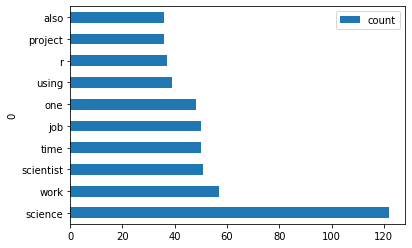

In [60]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in ds_index])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

### Top 10 Learnprogramming reddit words

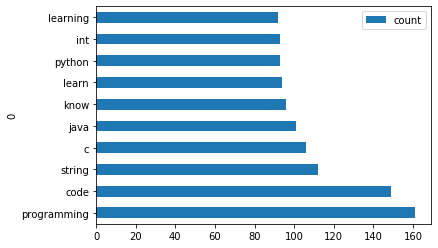

In [62]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in lp_index])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

## Misclassified words

In [63]:
# False Positive
# Post that are suppose to be in ds but classified as lp
ds_index_misclass = ds_lp_df[(ds_lp_df['lr'] == 'learnprogramming') & (ds_lp_df['label'] == 'datascience')].index 

# False Negative
# Post that are suppose to be in lp but classified as ds
lp_index_misclass = ds_lp_df[(ds_lp_df['lr'] == 'datascience') & (ds_lp_df['label'] == 'learnprogramming')].index 


### Top 10 Reddit misclassified words for datascience
Post that are suppose to be in datascience but are classified as learnprogramming

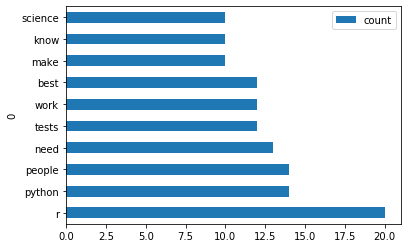

In [64]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in ds_index_misclass])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

### Top 10 Reddit misclassified words for learnprogramming
Post that are suppose to be in learnprogramming but are classified as datascience

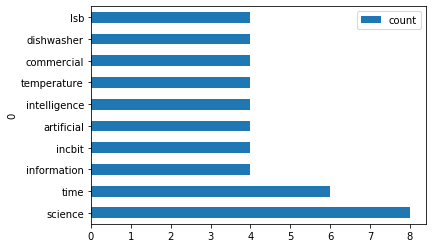

In [65]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in lp_index_misclass])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

Removed stemmer to make words to be more readable

In [66]:
def clean_text(raw_text, customize_stops):
    raw_text = re.sub(r'http[s]{0,1}://[^\s]*', '', raw_text) # Strip urls
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) # Remove non-letters
    
    words = letters_only.lower().split() # Convert to lower case, split to individual words
    stops = set(stopwords.words('english')) # Default storpwords
    stops.update(customize_stops) # Add customize stopwords
    meaningful_words = [w for w in words if w not in stops]  
    p_stemmer = PorterStemmer()
#     meaningful_words = [p_stemmer.stem(i) for i in meaningful_words] # Stem words
    
    return(" ".join(meaningful_words))

In [67]:
X,y,df = get_clean_subreddits('datascience', 'learnprogramming', 
                    customize_stops={'datascience','learnprogramming','lt','gur',
                                     'cur','gt','amp','data','get','want','like','would','use','new','x','b'})


Number of rows in subreddit datascience : 827
Number of rows in subreddit learnprogramming : 976
Baseline accuracy: 0.5413200221852468

Displaying first 5 rows of cleaned data and labels...


,text,subreddit
0,bleep bloop welcome week entering transitionin...,datascience
1,r grown considerably past year k subscribers j...,datascience
2,hello everyone currently science trainee start...,datascience
3,interview coming task scientist actual dataset...,datascience
4,hi everyone senior tax accountant one big four...,datascience


Examples of misclassified text for datascience
(Post that are suppose to be in datascience but are classified as learnprogramming)

In [86]:
df.loc[random.choice(ds_index_misclass)]['selftext']

"I have a link to a personal project on my resume, but I'm wondering if this is the best way to go about it. Would it be better to post it separately somewhere in the application?"

In [87]:
df.loc[random.choice(ds_index_misclass)]['selftext']

"Hi guys, I'm typically playing with data of several GBs, be it JSON or CSV. It's something I do at home, with my own pc and a little server I have (no fancy hardware, just don't want hear the fans running at night so I've installed the server in the living room).\n\nNow, I typically transform this data with Knime and PowerQuery because it's easy to work with, but they really struggle with the ~7Gb allocated for them. My sever has even less memory, and it's running other stuff.\n\nI tried all sorts of tricks but it becomes very slow, or just cannot work because of the available ram (Knime). I also tried with R and, yeah I get better results but it removes the fast&amp;easy element from it and it becomes a time sink. Same with python, where I'm even less proficient.\n\nI've been wondering about loading that data into a mariadb or sql database, and transforming that data in the server. I know databases are meant to work with this sort of problems, and I already know a bit of SQL, but I'm

Examples of misclassified text for datascience (Post that are suppose to be in learnprogramming but are classified as datascience)

In [88]:
df.loc[random.choice(lp_index_misclass)]['selftext']

"I'm planning to move there to study at that particular uni but I'm not sure if there's a point? Its fairly cheap and my Swedish student loan would cover everything nicely."

In [92]:
df.loc[random.choice(ds_index_misclass)]['selftext']

"So I know that I can use Pytest to write my own unit tests. I've written a bunch of unit tests for my applications. Now my question is, when do I run these tests? Are there some general guidelines or best practices on when to unit test?\n\nIs it a best practice to run these tests daily to see whether something changed in my environment that my application is dependent upon so I can verify that my application still works?Do I run these tests after every commit to verify that I did not break something?Are there other factors that come into play here?\n\nIn the same vein, should I put all my tests in a test suite that's isolated from the application being tested? Or should I put my test functions alongside the functions that are being tested? I figure the latter option is worse than the former because my application might break and that would also break my unit tests and I might not be able to tell - it's cleaner to separate tests from what's being tested so to avoid interferance. The co

# Extra

## Subreddit of python and learnpython

In [97]:
X,y,df = get_clean_subreddits('python', 'learnpython', 
                    customize_stops={'python','learnpython','learn','lt','gur','cur','gt','amp'})

python not found, proceed to scrape
Scraping python...
Scrapped 27 post...
Scrapped 52 post...
Scrapped 77 post...
Scrapped 102 post...
Scrapped 127 post...
Scrapped 152 post...
Scrapped 177 post...
Scrapped 202 post...
Scrapped 227 post...
Scrapped 252 post...
Scrapped 277 post...
Scrapped 302 post...
Scrapped 327 post...
Scrapped 352 post...
Scrapped 377 post...
Scrapped 402 post...
Scrapped 427 post...
Scrapped 452 post...
Scrapped 477 post...
Scrapped 502 post...
Scrapped 527 post...
Scrapped 552 post...
Scrapped 577 post...

learnpython not found, proceed to scrape
Scraping learnpython...
Scrapped 26 post...
Scrapped 51 post...
Scrapped 76 post...
Scrapped 101 post...
Scrapped 126 post...
Scrapped 151 post...
Scrapped 176 post...
Scrapped 201 post...
Scrapped 226 post...
Scrapped 251 post...
Scrapped 276 post...
Scrapped 301 post...
Scrapped 326 post...
Scrapped 351 post...
Scrapped 376 post...
Scrapped 401 post...
Scrapped 426 post...
Scrapped 451 post...
Scrapped 476 post...
Scr

,text,subreddit
0,starting today going enforcing flair requireme...,Python
1,tell r working week bragging grousing sharing ...,Python
2,wrote small library enable flexible piping fin...,Python
3,pandas released,Python
4,inspired post comments saying much boilerplate...,Python


In [98]:
p_lp_df = run_all_models(X,y)

----------------------- Logistic Regresson ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'lr']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'lr__penalty': ('none', 'l2'),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.5s finished


Best score: 0.838
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 10000
	cvec__ngram_range: (1, 1)
	lr__penalty: 'l2'
	tfidf__use_idf: False

Final model score

Train score: 0.9415807560137457
Test score: 0.7866323907455013

True Negatives: 72
False Positives: 73
False Negatives: 10
True Positives: 234

----------------------- K Nearest Neighbours ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'knn']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'knn__n_neighbors': [3, 5, 11],
 'knn__weights': ['uniform', 'distance'],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   25.2s finished
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.766
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 5000
	cvec__ngram_range: (1, 1)
	knn__n_neighbors: 11
	knn__weights: 'distance'
	tfidf__use_idf: False

Final model score

Train score: 0.9982817869415808
Test score: 0.7480719794344473

True Negatives: 68
False Positives: 77
False Negatives: 21
True Positives: 223

----------------------- Naive Bayes ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'nb']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'nb__alpha': (1, 2),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.0s finished


Best score: 0.741
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	nb__alpha: 1
	tfidf__use_idf: True

Final model score

Train score: 0.8273195876288659
Test score: 0.6760925449871465

True Negatives: 20
False Positives: 125
False Negatives: 1
True Positives: 243

----------------------- Random Forest ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'rf']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'rf__max_depth': [1, 2, None],
 'rf__n_estimators': [100, 150],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.1min finished


Best score: 0.846
Best parameters set:
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	rf__max_depth: None
	rf__n_estimators: 100
	tfidf__use_idf: False

Final model score

Train score: 0.9982817869415808
Test score: 0.8174807197943444

True Negatives: 91
False Positives: 54
False Negatives: 17
True Positives: 227

----------------------- Extra Trees ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'et']
parameters:
{'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'et__n_estimators': [50, 100, 150],
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   50.1s finished


Best score: 0.850
Best parameters set:
	cvec__max_df: 1.0
	cvec__max_features: 10000
	cvec__ngram_range: (1, 1)
	et__n_estimators: 50
	tfidf__use_idf: False

Final model score

Train score: 0.9982817869415808
Test score: 0.8174807197943444

True Negatives: 92
False Positives: 53
False Negatives: 18
True Positives: 226

----------------------- Ada Boost ------------------------
Performing grid search...
pipeline: ['cvec', 'tfidf', 'ada']
parameters:
{'ada__n_estimators': [50, 75, 100],
 'cvec__max_df': (0.5, 1.0),
 'cvec__max_features': (2500, 5000, 10000),
 'cvec__ngram_range': ((1, 1), (1, 2)),
 'tfidf__use_idf': (True, False)}

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   56.6s finished


Best score: 0.801
Best parameters set:
	ada__n_estimators: 50
	cvec__max_df: 0.5
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	tfidf__use_idf: False

Final model score

Train score: 0.8797250859106529
Test score: 0.8071979434447301

True Negatives: 97
False Positives: 48
False Negatives: 27
True Positives: 217



In [100]:
model_scores = {model: len(p_lp_df[p_lp_df[model] == p_lp_df['label']]) 
                / len(p_lp_df) for model in models}
model_scores

{'lr': 0.7866323907455013,
 'knn': 0.7480719794344473,
 'nb': 0.6760925449871465,
 'rf': 0.8174807197943444,
 'et': 0.8174807197943444,
 'ada': 0.8071979434447301}

In [106]:
p_lp_df['p_count'] = p_lp_df[p_lp_df[models_list] =='Python'].count(axis=1)
p_lp_df['lp_count'] = p_lp_df[p_lp_df[models_list] =='learnpython'].count(axis=1)


Text with different classifications among models

In [108]:
p_lp_df[p_lp_df['p_count'] == 3]

,text,lr,knn,nb,rf,et,ada,label,p_count,lp_count
392,want run applications esp microcontroller boar...,learnpython,Python,learnpython,Python,Python,learnpython,Python,3,3
476,person coming javascript important idiosyncras...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
200,best way practice improve writing code learnin...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
213,hey want dapple ac transit api check actransit...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
20,pystencils uses sympy define stencil operation...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
545,time sixth discord code jam year got brand new...,Python,Python,learnpython,learnpython,learnpython,Python,Python,3,3
1539,per title looking recommendation books assist ...,learnpython,learnpython,learnpython,Python,Python,Python,learnpython,3,3
216,terminusdb foss graph db stores data like git ...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
217,full course beginners first part basic second ...,learnpython,learnpython,learnpython,Python,Python,Python,Python,3,3
639,hi background sql theoretical knowledge oops w...,learnpython,learnpython,learnpython,Python,Python,Python,learnpython,3,3


## Correctly classified words

In [110]:
# True positive
lp_index = p_lp_df[(p_lp_df['lr'] == p_lp_df['label']) & (p_lp_df['label'] == 'learnpython')].index

# True negative
p_index = p_lp_df[(p_lp_df['lr'] == p_lp_df['label']) & (p_lp_df['label'] == 'Python')].index


### Top 10 Python reddit words
Join all text in correctly classified words, tokenize text and then plot most common occurances

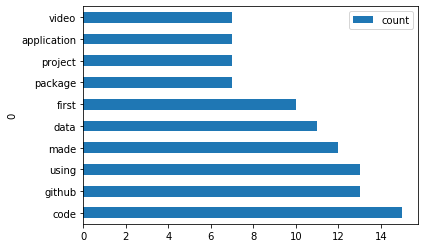

In [111]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in p_index])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

### Top 10 Learnpython reddit words

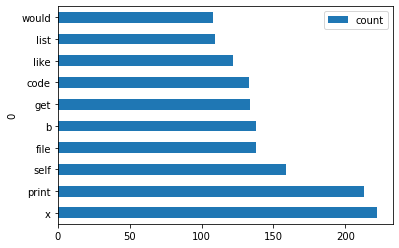

In [112]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in lp_index])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

## Misclassified words

In [119]:
# False Positive
# Post that are suppose to be in learnpython but classified as python
lp_index_misclass = p_lp_df[(p_lp_df['lr'] == 'Python') & (p_lp_df['label'] == 'learnpython')].index 

# False Negative
# Post that are suppose to be in python but classified as learnpython
p_index_misclass = p_lp_df[(p_lp_df['lr'] == 'learnpython') & (p_lp_df['label'] == 'Python')].index 


### Top 10 Reddit misclassified words for python
Post that are suppose to be in python but are classified as learnpython

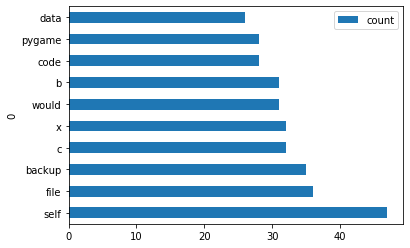

In [120]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in p_index_misclass])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

### Top 10 Reddit misclassified words for learnpython
Post that are suppose to be in learnpython but are classified as python

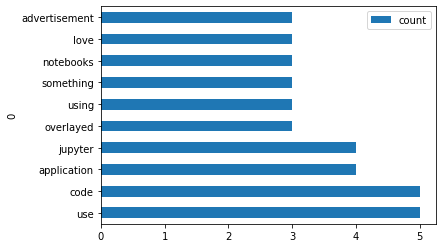

In [118]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['text'].values[0] for i in lp_index_misclass])
                     .split()).most_common()).head(10).set_index(0).rename(columns={1:'count'}).plot(kind='barh')

## Conclusion
- Different model works well in different subreddit
- There is no one model that can work well for all subreddit
- Best model is logistic regression
- Best parameters for count vectorizer is 1 gram tokenize with 2500 max features, using tfidf transform
- Some of the misleading words that is oftenly misclassified includes 'python', 'r', 'people', 'work', 'science' for data science and 'artificial', 'intelligence', 'information', 'time' for learn programming